In [1]:
import ray

In [ ]:
ray.init(_temp_dir='C:/Users/michn/PycharmProjects/Distributed-Systems/project_ray_ml/temp')

In [3]:
from typing import Any, Dict
from torchvision import transforms

from ray.data.datasource.partitioning import Partitioning, PartitionStyle
import os
import numpy as np

data_directory = "dataset"
partitioning_test = Partitioning(PartitionStyle("dir"), field_names=["label"], base_dir=os.path.join(data_directory, 'test_set'))
partitioning_train = Partitioning(PartitionStyle("dir"), field_names=["label"], base_dir=os.path.join(data_directory, 'train_set'))

def transform_image(row: Dict[str, Any]) -> Dict[str, Any]:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    row["image"] = transform(row["image"])
    row["label"] = 1 if row["label"] == "cats" else 0
    return row

test_set = (
    ray.data.read_images(f"{data_directory}/test_set", partitioning=partitioning_test, shuffle="files")
    .map(transform_image)
)

train_set = (
    ray.data.read_images(f"{data_directory}/train_set", partitioning=partitioning_train, shuffle="files")
    .map(transform_image)
)

In [4]:
single_batch = test_set.take_batch(16)

2024-04-23 02:38:07,719	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in C:/Users/michn/PycharmProjects/Distributed-Systems/project_ray_ml/temp\session_2024-04-23_02-37-43_821478_5456\logs/ray-data.log
2024-04-23 02:38:07,719	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map(transform_image)] -> LimitOperator[limit=16]



- ReadImage->Map(transform_image) 1:   0%|          | 0/44 [00:00<?, ?it/s]

- limit=16 2:   0%|          | 0/44 [00:00<?, ?it/s]

Running 0:   0%|          | 0/44 [00:00<?, ?it/s]

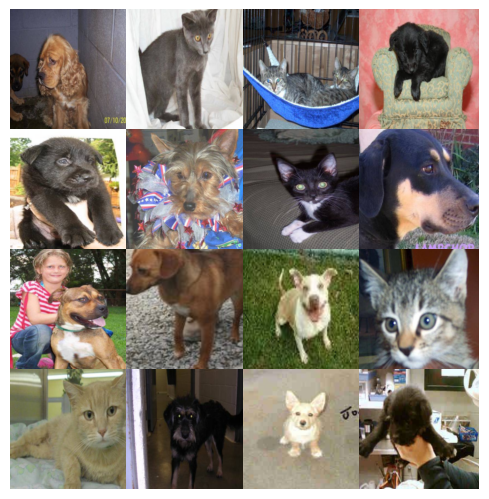

              0              1              1              0
              0              0              1              0
              0              0              0              1
              1              0              0              0


In [5]:
import matplotlib.pyplot as plt
from itertools import product


def show_images(images):
    _, axes = plt.subplots(4, 4)

    for (pos_x, pos_y), img in zip(product(range(4), range(4)), images):
        img = img.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        axes[pos_x][pos_y].imshow(img)
        axes[pos_x][pos_y].axis('off')

    plt.subplots_adjust(left=0.0,
                        bottom=0.0,
                        right=1,
                        top=1,
                        wspace=-.6,
                        hspace=0)
    plt.show()

def label_images(class_labels):
    for j in range(4):
        print("".join(f"{x:15}" for x in class_labels[4*j:4*j+4]))

imgs= single_batch['image']
labels = single_batch['label']

show_images(imgs)
label_images(labels)

In [6]:
import os
import tempfile
import torch
from torch import sigmoid
from torch import nn
import ray.train.torch


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(40000, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1)
        )

    def forward(self, x):
        return self.cnn(x)

    def predict_proba(self, x):
        return sigmoid(self(x))

    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)

In [13]:
from torch import optim
from ray import train

def train_func():
    model = CNN()
    model = ray.train.torch.prepare_model(model)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters())

    train_data_shard = train.get_dataset_shard("train")

    for epoch in range(10):
        for batch in train_data_shard.iter_torch_batches(batch_size=32, dtypes=torch.float32):
            images = batch['image']
            y_true = batch['label']
            y_pred = model(images)
            loss = criterion(torch.squeeze(y_pred), y_true.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            metrics = {"loss": loss.item(), "epoch": epoch}
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                torch.save(
                    model.module.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pt")
                )
                ray.train.report(
                    metrics,
                    checkpoint=ray.train.Checkpoint.from_directory(temp_checkpoint_dir),
                )
            if ray.train.get_context().get_world_rank() == 0:
                print(metrics)


scaling_config = ray.train.ScalingConfig(num_workers=2)

trainer = ray.train.torch.TorchTrainer(
    train_func,
    datasets={"train": train_set},
    scaling_config=scaling_config,
)

result = trainer.fit()

2024-04-22 23:35:42,259	INFO data_parallel_trainer.py:332 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.


(pid=7716) - ReadImage->Map(transform_image) 1:   0%|          | 0/51 [00:00<?, ?it/s]

(pid=7716) - split(2, equal=True) 2:   0%|          | 0/51 [00:00<?, ?it/s]

(pid=7716) Running 0:   0%|          | 0/51 [00:00<?, ?it/s]

2024-04-22 23:38:34,288	WARNING util.py:202 -- The `on_step_begin` operation took 0.549 s, which may be a performance bottleneck.
2024-04-22 23:39:51,129	WARNING util.py:202 -- The `on_step_begin` operation took 31.466 s, which may be a performance bottleneck.
2024-04-22 23:41:08,284	ERROR tune_controller.py:1332 -- Trial task failed for trial TorchTrainer_45056_00000
Traceback (most recent call last):
  File "C:\Users\michn\PycharmProjects\Distributed-Systems\project_ray_ml\venv\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "C:\Users\michn\PycharmProjects\Distributed-Systems\project_ray_ml\venv\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\michn\PycharmProjects\Distributed-Systems\project_ray_ml\venv\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, 

TrainingFailedError: The Ray Train run failed. Please inspect the previous error messages for a cause. After fixing the issue (assuming that the error is not caused by your own application logic, but rather an error such as OOM), you can restart the run from scratch or continue this run.
To continue this run, you can use: `trainer = TorchTrainer.restore("C:/Users/michn/ray_results/TorchTrainer_2024-04-22_23-35-42")`.
To start a new run that will retry on training failures, set `train.RunConfig(failure_config=train.FailureConfig(max_failures))` in the Trainer's `run_config` with `max_failures > 0`, or `max_failures = -1` for unlimited retries.